**Video Games Recommendation**

**Import the Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

**Import the data set to the machine**

In [2]:
video_games_df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

print(f"No. of records: {video_games_df.shape[0]}")
video_games_df.head(5)

No. of records: 16719


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


**We here only filter out features that are relevant for our recommendation system.**

In [3]:
video_games_filtered_df = video_games_df[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


**Data Preprocessing begins from here on wards**


**Check the total number of missing values for each feature in the dataset**

In [4]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

**Here We are going to remove the missing values for Name, Genre and Ratings features**

In [5]:

video_games_filtered_df.dropna(subset=['Name', 'Genre', 'Rating'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)



**Now recheck whether more missing values are available**

In [33]:
video_games_filtered_df[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

**Now We are going to check the class Imbalance**

**Frequency distribution of the features type Genre, Platform, and Rating**

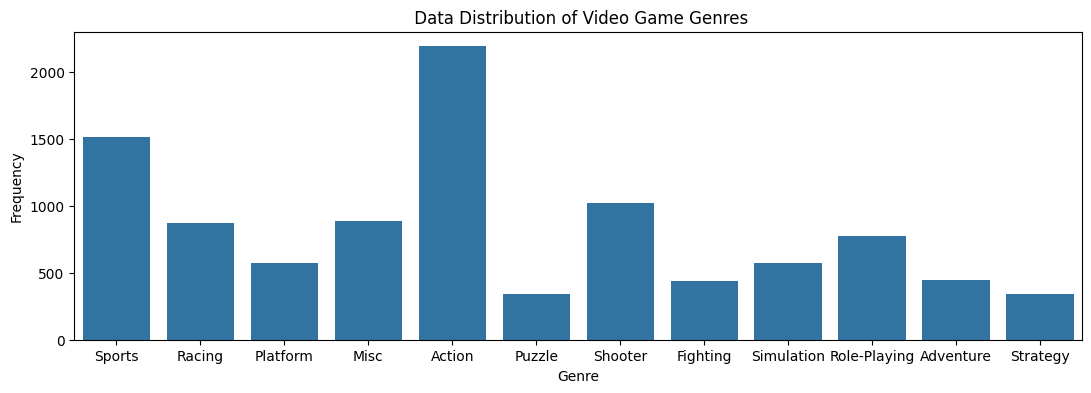

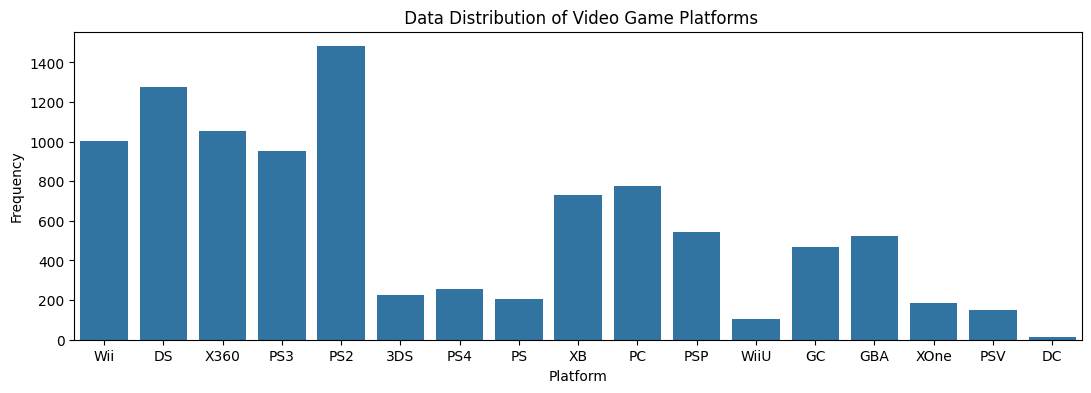

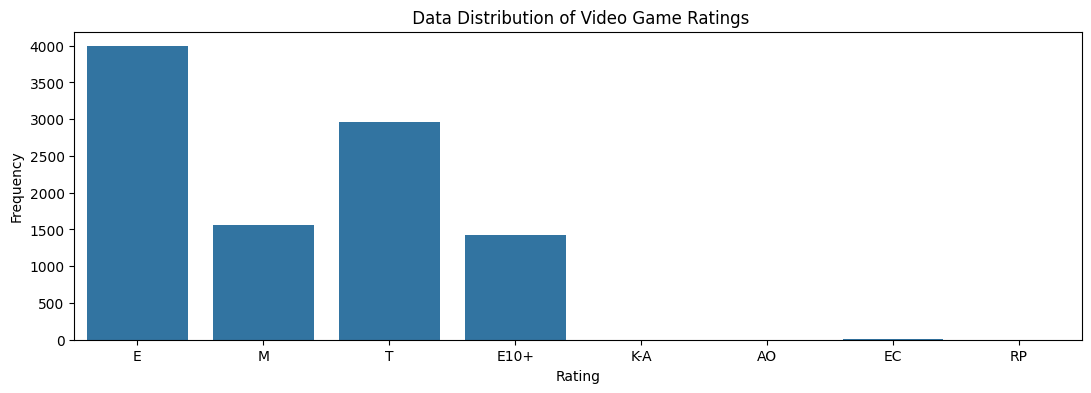

In [7]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (13,4))
    sns.countplot(data=video_games_filtered_df, x=feature)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(" Data Distribution of Video Game " + feature + "s")
plt.show()

**Data imbalance is observed, with class scarcity present for certain rating methods such as 'K-A', 'AO', 'EC', and 'RP'.**

**We calculated the average of the User_Score and Critic_Score variables and created two additional columns, Avg_User_Score and Avg_Critic_Score, to capture these respective mean values**

**In this step, the column is checked for any occurrences of 'tbd' values, which are then replaced with np.nan, indicating missing values. After this conversion, the column is cast to a float data type, as NaN values can only exist in numerical data types.**

In [8]:
video_games_filtered_df['User_Score'] = np.where(video_games_filtered_df['User_Score'] == 'tbd',
                                                 np.nan,
                                                 video_games_filtered_df['User_Score']).astype(float)

**Now group the records by Genre, then aggregate them calculating the average of both Critic Score and User Score**

In [9]:
video_game_grpby_genre = video_games_filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False)

video_game_score_mean = video_game_grpby_genre.agg(Ave_Critic_Score = ('Critic_Score', 'mean'), Ave_User_Score = ('User_Score', 'mean'))

**Now add the new average values to the main dataframe**

In [10]:
video_games_filtered_df = video_games_filtered_df.merge(video_game_score_mean, on='Genre')
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126
1,Mario Kart Wii,Wii,Racing,82.0,8.3,E,67.927694,7.036767
2,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126
3,New Super Mario Bros.,DS,Platform,89.0,8.5,E,68.058350,7.301402
4,Wii Play,Wii,Misc,58.0,6.6,E,66.650672,6.827460
...,...,...,...,...,...,...,...,...
9945,Bust-A-Move 3000,GC,Puzzle,53.0,NaN,E,67.418919,7.175000
9946,Mega Brain Boost,DS,Puzzle,48.0,NaN,E,67.418919,7.175000
9947,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.254296,7.320930
9948,Plushees,DS,Simulation,NaN,NaN,E,68.587896,7.136686


**In this step, the missing values in the Critic_Score column are imputed with the corresponding average critic score (Ave_Critic_Score), while existing values remain unchanged. This ensures that missing critic scores are replaced with a meaningful estimate.**

In [11]:
video_games_filtered_df['Critic_Score_Imputed'] = np.where(video_games_filtered_df['Critic_Score'].isna(),
                                                           video_games_filtered_df['Ave_Critic_Score'],
                                                           video_games_filtered_df['Critic_Score'])

**The same thing has been done for the user_score**

In [12]:
video_games_filtered_df['User_Score_Imputed'] = np.where(video_games_filtered_df['User_Score'].isna(),
                                                         video_games_filtered_df['Ave_User_Score'],
                                                         video_games_filtered_df['User_Score'])

**Review the dataset after the relavant changes**

In [13]:
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Imputed,User_Score_Imputed
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126,76.000000,8.000000
1,Mario Kart Wii,Wii,Racing,82.0,8.3,E,67.927694,7.036767,82.000000,8.300000
2,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126,80.000000,8.000000
3,New Super Mario Bros.,DS,Platform,89.0,8.5,E,68.058350,7.301402,89.000000,8.500000
4,Wii Play,Wii,Misc,58.0,6.6,E,66.650672,6.827460,58.000000,6.600000
...,...,...,...,...,...,...,...,...,...,...
9945,Bust-A-Move 3000,GC,Puzzle,53.0,NaN,E,67.418919,7.175000,53.000000,7.175000
9946,Mega Brain Boost,DS,Puzzle,48.0,NaN,E,67.418919,7.175000,48.000000,7.175000
9947,STORM: Frontline Nation,PC,Strategy,60.0,7.2,E10+,72.254296,7.320930,60.000000,7.200000
9948,Plushees,DS,Simulation,NaN,NaN,E,68.587896,7.136686,68.587896,7.136686


**Review the needed four columns to see whether there is any huge change or not in the data set after creating 2 extra columns**

**Here only the 4 main attributes are taken in to the consideration and then the describe function is being used to get the overall view of the data set.**

In [14]:
video_games_filtered_df[['Critic_Score', 'Critic_Score_Imputed', 'User_Score', 'User_Score_Imputed']].describe()

,Critic_Score,Critic_Score_Imputed,User_Score,User_Score_Imputed
count,8054.000000,9950.000000,7504.000000,9950.000000
mean,68.971319,68.851751,7.126879,7.107768
std,13.951640,12.594336,1.500750,1.305869
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,63.000000,6.400000,6.800000
50%,71.000000,69.000000,7.500000,7.136686
75%,79.000000,77.000000,8.200000,8.000000
max,98.000000,98.000000,9.700000,9.700000


**Here we are going to drop the not needed features but do not drop the newly created featurs**

In [15]:
video_games_final_df = video_games_filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
video_games_final_df = video_games_final_df.reset_index(drop=True)

**View the final set of data**

In [16]:

video_games_final_df = video_games_final_df.rename(columns={'Critic_Score_Imputed':'Critic_Score', 'User_Score_Imputed':'User_Score'})
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


**Encoding begings from here.First get the features which are in catergorical data except the name.**

In [17]:
categorical_columns = [name for name in video_games_final_df.columns if video_games_final_df[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 3 categorical features:

Platform, Genre, Rating


**Convert all catergorical data to binary and review it using the head function**

In [18]:
video_games_df_dummy = pd.get_dummies(data=video_games_final_df, columns=categorical_columns)
video_games_df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,76.0,8.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
1,Mario Kart Wii,82.0,8.3,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,Wii Sports Resort,80.0,8.0,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
3,New Super Mario Bros.,89.0,8.5,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,Wii Play,58.0,6.6,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


**Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable**.

**The data distribution issues will get reduce by this method**

In [19]:
features = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0.567605,0.683282,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
1,1.044034,0.913026,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
2,0.885224,0.683282,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
3,1.599867,1.066188,-0.15314,-0.037537,2.609607,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
4,-0.861681,-0.388855,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,-1.258704,0.051487,-0.15314,-0.037537,-0.383200,-0.235302,4.496149,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
9946,-1.655728,0.051487,-0.15314,-0.037537,2.609607,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
9947,-0.702871,0.070632,-0.15314,-0.037537,-0.383200,-0.235302,-0.222413,3.443152,-0.146119,-0.418178,...,-0.422812,5.324569,-0.010026,-0.818378,2.450927,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
9948,-0.020951,0.022146,-0.15314,-0.037537,2.609607,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,-0.422812,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896


In [20]:
# Save scaled data for future use
import pickle


with open('scaled_features.pkl', 'wb') as f:
    pickle.dump(scaled_features, f)

**Data cleaning and preprocessing is done .Here onwards we starts the data modeling section.**

**The data modeling approaches include collaborative filtering, content-based filtering, and hybrid methods.**

**Collaborative filtering is implemented first to provide recommendations based on user behavior and preferences.**

**NearestNeighbors will be utilized to identify the data points nearest to a given input, with the aid of the cosine similarity measurement to determine the similarity or dissimilarity between data points.**

In [21]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


In [22]:
# Save the model
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load model when needed
with open('knn_model.pkl', 'rb') as f:
    model = pickle.load(f)

**The indexes and distances for the nearest neighbors of the first 5 games are displayed using the kneighbors method, showing the closest games based on the scaled feature set**

In [23]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for the first 5 games:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for the first 5 games:

[[   0 3228 3812 1091    2 3555 2812    7 1635 3314 1062]
 [   1 4447 2648 3818 3200 5731 3291 2917 4782 1660 7624]
 [   2 2812 1091    7 1635    0 3228 2741 4139 1170 2595]
 [   3 1989 1435  310 8036 1210 1059 3986 7920 4218  384]
 [   4 3333   54 3101 5314  991  208  650 5178 7952 4432]] 

[[0.00000000e+00 1.45719262e-04 7.95959057e-04 1.52363383e-03
  2.48420244e-03 2.76264905e-03 3.85590684e-03 3.90039612e-03
  4.56853634e-03 4.76778616e-03 4.88365814e-03]
 [1.11022302e-16 4.12331472e-03 1.25114932e-02 1.79102267e-02
  1.83496406e-02 2.76557305e-02 2.76557305e-02 3.40316310e-02
  3.42846867e-02 3.53362240e-02 4.36579924e-02]
 [1.11022302e-16 1.50397540e-04 3.04331263e-04 1.30700527e-03
  2.23694972e-03 2.48420244e-03 2.65392852e-03 2.71666441e-03
  3.38307214e-03 3.38307214e-03 3.43195161e-03]
 [2.22044605e-16 1.60977583e-03 3.62042660e-03 4.76682680e-03
  1.20358234e-02 1.27341263e-02 1.30603498e-02 1.37578769e-02
  1.60735434e

**Now will move to the content base filtering by usinf TF-IDF approach**

In [24]:
game_names = video_games_df_dummy['Name'].drop_duplicates().reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True).fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [25]:
game_title_vectors = vectorizer.transform(game_names)

print("List of game title vectors for the first 5 games:\n")
print(pd.DataFrame(game_title_vectors.toarray()).head(5))

List of game title vectors for the first 5 games:

   0     1     2     3     4     5     6     7     8     9     ...  4812  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   4813  4814  4815  4816  4817  4818  4819  4820  4821  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4822 columns]


In [26]:
# Save TF-IDF vectorizer for future use
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


**The model evaluation is completed using a hybrid approach, integrating both collaborative filtering and content-based filtering techniques.**

In [34]:
from fuzzywuzzy import process

def VideoGameTitleRecommender(video_game_name):
    closest_match = process.extractOne(video_game_name, game_names)
    return closest_match[0]  # returns the best match

**The below function will recomend a agame title which is closest match to the input**

In [35]:
# Main game recommendation function
def VideoGameRecommender(video_game_name, video_game_platform='Any'):
    '''
    This function will provide game recommendations based on various features of the game.
    It uses both collaborative filtering and content-based filtering.
    '''
    default_platform = 'Any'

    # Clean and normalize the input game name
    video_game_name = video_game_name.lower().strip()

    # Ensure that the game names in the dataframe are also normalized for consistency
    video_games_final_df['Name'] = video_games_final_df['Name'].str.lower().str.strip()

    # User input: Game Title and Platform
    if video_game_platform != default_platform:
        video_game_idx = video_games_final_df.query("Name == @video_game_name & Platform == @video_game_platform").index

        # If game with specified platform doesn't exist, check without the platform
        if len(video_game_idx) == 0:
            video_game_idx = video_games_final_df.query("Name == @video_game_name").index

            if len(video_game_idx) > 0:
                print(f"Note: Recommendations will be based on the title of the game as it is not available on the specified platform.\n")
                video_game_platform = default_platform

    else:
        video_game_idx = video_games_final_df.query("Name == @video_game_name").index

    # If no match is found in the dataset
    if len(video_game_idx) == 0:
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)
        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
    else:
        # Content-based filtering and collaborative filtering hybrid
        if video_game_platform == default_platform:
            vg_combined_dist_idx_df = pd.DataFrame()

            # Collect recommendations based on multiple similar games
            for idx in video_game_idx:
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx][1:]), pd.DataFrame(vg_distances[idx][1:])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            # Set proper axis labels and reset index
            vg_combined_dist_idx_df.columns = ['Index', 'Distance']
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            # Retrieve the list of recommended games
            video_game_list = video_games_final_df.iloc[vg_combined_dist_idx_df['Index']]
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')  # Remove duplicates

            # Get the top 10 games
            video_game_list = video_game_list.head(10)
            recommended_distances = np.array(vg_combined_dist_idx_df['Distance'].head(10))

        else:
            # If specific platform is provided, generate recommendations for the closest match
            recommended_idx = vg_indices[video_game_idx[0]][1:]
            video_game_list = video_games_final_df.iloc[recommended_idx]
            recommended_distances = np.array(vg_distances[video_game_idx[0]][1:])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform: {video_game_platform}]:\n")

        # Merge the recommendation list with the distances
        video_game_list = video_game_list.reset_index(drop=True)
        recommended_video_game_list = pd.concat([video_game_list, pd.DataFrame(recommended_distances, columns=['Similarity_Distance'])], axis=1)

        # Display the top 10 recommendations
        recommended_video_game_list.reset_index(drop=True, inplace=True)
        display(recommended_video_game_list[['Name', 'Platform', 'Similarity_Distance']])

In [36]:
# Example usage of VideoGameRecommender function
VideoGameRecommender("Super Mario", "Nintendo")

'super mario' doesn't exist in the records.

You may want to try 'New Super Mario Bros.', which is the closest match to the input.



**Evaluation of the model starts here. You can call the function below to test the recommendations based on both the user-preferred game name and platform.**

In [37]:
VideoGameRecommender('Call of Duty: World at War', 'PC')

Top 10 Recommended Video Games for 'call of duty: world at war' [platform: PC]:



,Name,Platform,Similarity_Distance
0,halo: combat evolved,PC,0.000096
1,red faction: guerrilla,PC,0.000099
2,bulletstorm,PC,0.000486
3,quake 4,PC,0.000499
4,borderlands,PC,0.001273
5,crysis: warhead,PC,0.001594
6,doom 3,PC,0.001621
7,max payne 3,PC,0.001621
8,gears of war,PC,0.002337
9,unreal tournament iii,PC,0.002359


In [38]:
VideoGameRecommender('Call of Duty: World at War', 'Any')

Top 10 Recommended Video Games for 'call of duty: world at war' [platform: Any]:



,Name,Platform,Similarity_Distance
0,bulletstorm,X360,1.110223e-16
1,halo: combat evolved,PC,9.554833e-05
2,red faction: guerrilla,PC,9.921157e-05
3,battlefield 3,PS3,1.020339e-04
4,tom clancy's rainbow six: vegas,PS3,1.029739e-04
5,unreal tournament iii,PS3,2.000959e-04
6,quake 4,PC,4.266633e-04
7,max payne 3,PS3,4.410591e-04
8,resistance 3,PS3,4.857106e-04
9,tom clancy's rainbow six: vegas 2,X360,4.990671e-04


**Since the video game is not available on the specified platform, the recommendation is based solely on the game title and ignores the platform.**

In [39]:
VideoGameRecommender('Red Faction: Guerrilla', 'Any')

Top 10 Recommended Video Games for 'red faction: guerrilla' [platform: Any]:



,Name,Platform,Similarity_Distance
0,call of duty: world at war,PC,0.000099
1,resistance: fall of man,PS3,0.000102
2,vanquish,PS3,0.000103
3,halo: combat evolved,PC,0.000197
4,quake 4,PC,0.000198
5,borderlands,X360,0.000216
6,bulletstorm,PC,0.000382
7,killzone 3,PS3,0.000491
8,crackdown,X360,0.000519
9,the darkness,X360,0.000793


**The platform helps to limit the results and display only recommended games based on the specified game and platform.**

In [40]:
VideoGameRecommender('Red Faction: Guerrilla', 'X360')

Top 10 Recommended Video Games for 'red faction: guerrilla' [platform: X360]:



,Name,Platform,Similarity_Distance
0,borderlands,X360,0.000216
1,crackdown,X360,0.000519
2,the darkness,X360,0.000971
3,halo: combat evolved anniversary,X360,0.000971
4,bioshock 2,X360,0.001003
5,vanquish,X360,0.001042
6,max payne 3,X360,0.001053
7,the chronicles of riddick: assault on dark athena,X360,0.001094
8,tom clancy's rainbow six: vegas,X360,0.001274
9,borderlands 2,X360,0.001702


In [41]:
video_games_filtered_df['Name'].unique()

array(['Wii Sports', 'Mario Kart Wii', 'Wii Sports Resort', ...,
       'Mega Brain Boost', 'STORM: Frontline Nation', 'Plushees'],
      dtype=object)

In [42]:
video_games_filtered_df['Platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS2', '3DS', 'PS4', 'PS', 'XB', 'PC',
       'PSP', 'WiiU', 'GC', 'GBA', 'XOne', 'PSV', 'DC'], dtype=object)